### Script to take thermal tuning data and calculate the spring constant using the Sader Method

#### Import required modules

In [1]:
import numpy as np
from NSFopen.read import read
import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sader import sader

font = {'size': 10}
matplotlib.rc('font', **font)

#### SHO oscillator function with White Noise

In [2]:
def SHO(x, *args):
    f0, Q, A0, WN = args
    qterm = 1 / Q**2
    wnterm = WN**2
    return WN + A0*f0**4/((x**2-f0**2)**2 + (x*f0/Q)**2)

#### Open thermal tune file

In [3]:
file = 'thermal.nid'

# cantilever dimensions in um
L = 225e-6
W = 40e-6

# open file and read Sweep data
afm = read(file)
amp = afm.data.Sweep.FFT['Amplitude Spectral Density'][0]

# define the frequencies (X-axis)
f_min = afm.param.X['min'][0]
f_range = afm.param.X.range[0]

freq = np.linspace(f_min, f_min + f_range, len(amp))

amp = amp[freq > 1000]
freq = freq[freq > 1000]

# find the resonance frequency at the peak amplitude
f0 = freq[np.where(amp == np.max(amp))[0][0]]
df = 15e3  # defines the bandwidth

# 
x = freq[(freq>f0-df) & (freq<f0+df)]
y = amp[(freq>f0-df) & (freq<f0+df)]

#### Setup fitting of SHO equation to thermal

In [4]:
p0 = [f0, 500, 1e-13, 1e-13]
# bounds = ((100,0,-np.inf,-np.inf),(np.inf))
coeff, _ = curve_fit(SHO, x, y, p0=p0)

#### Plot results and print spring constant from Sader

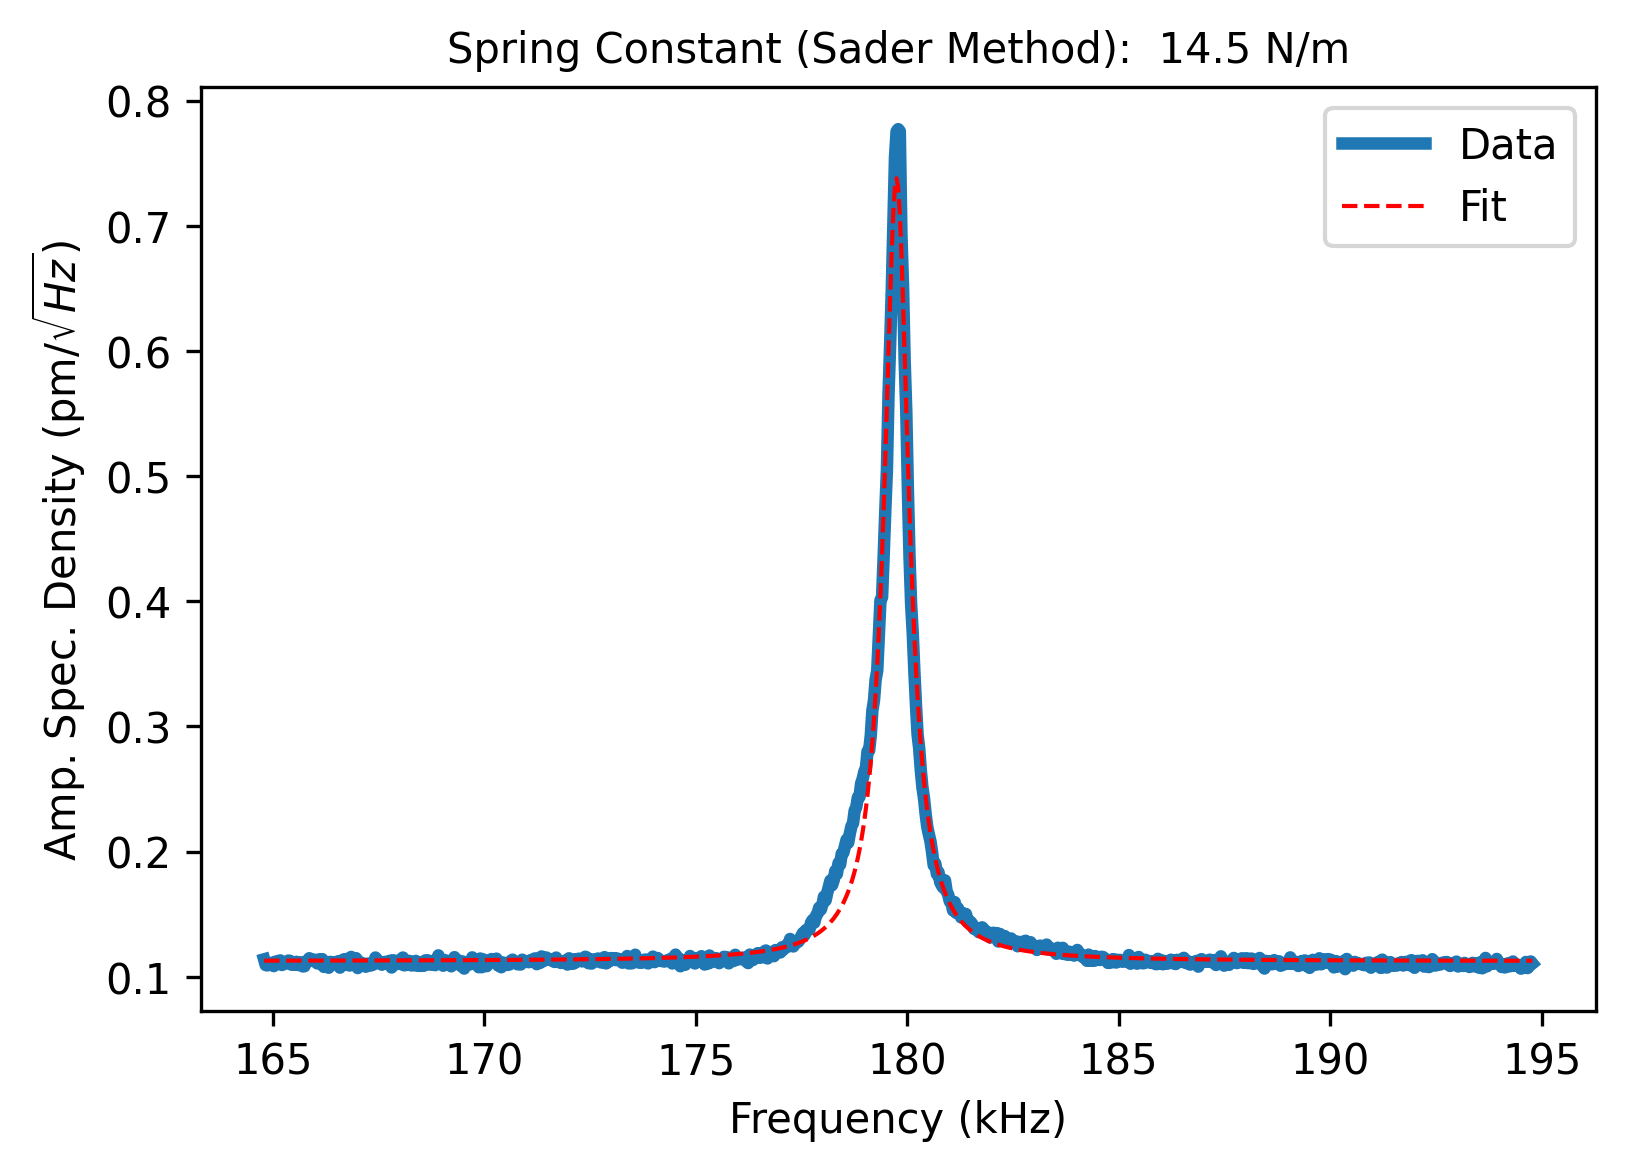

In [5]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.plot(x/1e3, y*1e12, linewidth=3)
plt.plot(x/1e3, SHO(x, *coeff)*1e12, linewidth = 1, color = 'r', linestyle = '--')
plt.title(f'Spring Constant (Sader Method): %5.1f N/m' % sader(L, W, *coeff), fontsize=10)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amp. Spec. Density (pm/$\sqrt{Hz}$)')
plt.legend(['Data', 'Fit'])